In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [2]:
PATH = "test-data/"
sz = 224

Does our directory structure look ok?

In [3]:
os.listdir(PATH)

['valid', 'models', 'train', 'tmp']

In [4]:
os.listdir(f'{PATH}valid')

['afl', 'hockey']

Is there a footy image there?

In [5]:
files = os.listdir(f'{PATH}valid/afl')[:4]
files

['89. maxresdefault.jpg',
 '27. maxresdefault.jpg',
 '52. 130530_home_hero.jpg',
 '9. gettyimages-611838498.jpg']

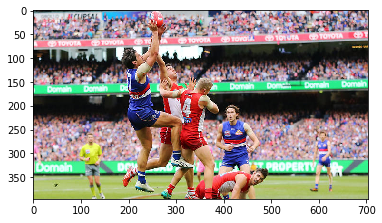

In [6]:
img = plt.imread(f'{PATH}valid/afl/{files[3]}')
plt.imshow(img)

In [7]:
img.shape

(396, 704, 3)

In [8]:
arch = resnet34
tfms = tfms_from_model(arch, sz)
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [57]:
learn.fit(0.01/1000, 4)

epoch      trn_loss   val_loss   accuracy                 
    0      0.068094   0.150343   0.942857  
    1      0.065387   0.154816   0.942857                 
    2      0.081104   0.149748   0.942857                 
    3      0.071264   0.143695   0.942857                 



[array([0.14369]), 0.9428571462631226]

Determine a reasonable learning rate

In [53]:
lrf = learn.lr_find(0.01/1000)

epoch      trn_loss   val_loss   accuracy                 
    0      0.05647    0.133979   0.942857  



Where does our loss stop decreasing

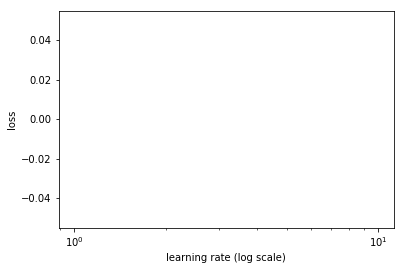

In [55]:
learn.sched.plot()

Ok, lets use x

Try data augmentation

In [58]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

Have a look at some of the changes

In [59]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [60]:
ims = np.stack([get_augs() for i in range(6)])

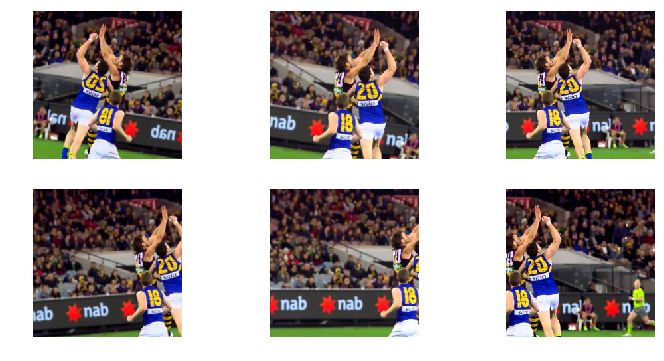

In [61]:
plots(ims, rows=2)

New 'data' object with the modified images

In [62]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [65]:
learn.fit(1e-4, 20)

epoch      trn_loss   val_loss   accuracy        
    0      0.378373   0.344192   0.828571  
    1      0.34253    0.341177   0.828571        
    2      0.312403   0.333698   0.857143        
    3      0.291856   0.328265   0.857143        
    4      0.273591   0.336145   0.857143        
    5      0.292214   0.33967    0.828571        
    6      0.27329    0.343306   0.828571        
    7      0.268023   0.344435   0.828571        
    8      0.25707    0.346123   0.828571        
    9      0.257058   0.342678   0.857143        
    10     0.258072   0.339415   0.857143        
    11     0.25735    0.333754   0.857143        
    12     0.25932    0.335751   0.857143        
    13     0.25898    0.341723   0.828571        
    14     0.263235   0.332533   0.857143        
    15     0.262555   0.328651   0.857143        
    16     0.259619   0.324784   0.857143        
    17     0.262597   0.330431   0.857143        
    18     0.257959   0.329746   0.857143        
    19

[array([0.32658]), 0.8571428656578064]

Better, apply stochastic gradient descent with restarts (SGDR)

In [66]:
learn.precompute = False

In [67]:
learn.fit(1e-4, 30, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                
    0      0.314963   0.327416   0.857143  
    1      0.290996   0.328603   0.857143                
    2      0.306844   0.327654   0.857143                
    3      0.314521   0.333334   0.828571                
    4      0.322144   0.33162    0.828571                
    5      0.314409   0.321313   0.857143                
    6      0.298355   0.316286   0.857143                
    7      0.296095   0.320437   0.857143                
    8      0.2946     0.313891   0.857143                
    9      0.296859   0.31068    0.857143                
    10     0.290717   0.32127    0.857143                
    11     0.284351   0.320722   0.857143                
    12     0.280844   0.318639   0.857143                
    13     0.289808   0.326737   0.857143                
    14     0.285457   0.322705   0.857143                
    15     0.287386   0.326042   0.857143                
    16     0.285104   0.3224

[array([0.31663]), 0.8571428656578064]

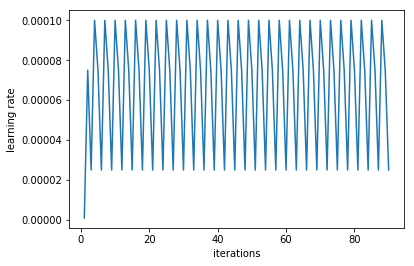

In [68]:
learn.sched.plot_lr()

Save it for later

In [21]:
learn.save('afl_lastlayer')

In [22]:
learn.load('afl_lastlayer')

Try fine tuning the other hidden layers, by unfreezing them and giving different learning rates for different layers (differential learning rates)

In [69]:
learn.unfreeze()
lr = np.array([1e-4, 1e-3, 1e-2])

In [70]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                
    0      0.489182   0.333547   0.885714  
    1      0.499427   0.246352   0.885714                
    2      0.485799   0.212416   0.914286                
    3      0.44368    0.120189   1.0                     
    4      0.406445   0.072596   1.0                     
    5      0.369522   0.064756   1.0                     
    6      0.335295   0.0703     1.0                     



[array([0.0703]), 1.0]

Lets plot that learning rate

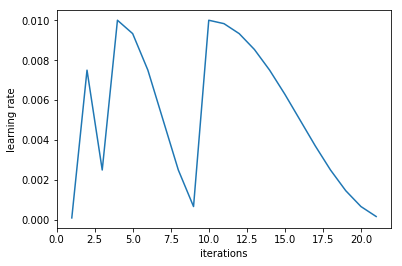

In [71]:
learn.sched.plot_lr()

In [90]:
learn.save('afl_all')

In [91]:
learn.load('afl_all')

Apply test time augmentation (TTA)

In [74]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [75]:
accuracy_np(probs, y)

1.0

Confusion Matrix

In [76]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [77]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[16  0]
 [ 0 19]]


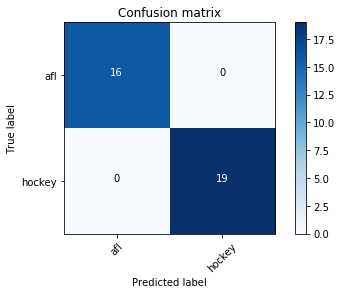

In [78]:
plot_confusion_matrix(cm, data.classes)

In [79]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [80]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [81]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [82]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

In [83]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect AFL")

Most incorrect AFL


<Figure size 1152x576 with 0 Axes>

In [84]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect Hockey")

Most incorrect Hockey


<Figure size 1152x576 with 0 Axes>

In [39]:
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

In [40]:
data.classes

['afl', 'hockey']

Correctly classified


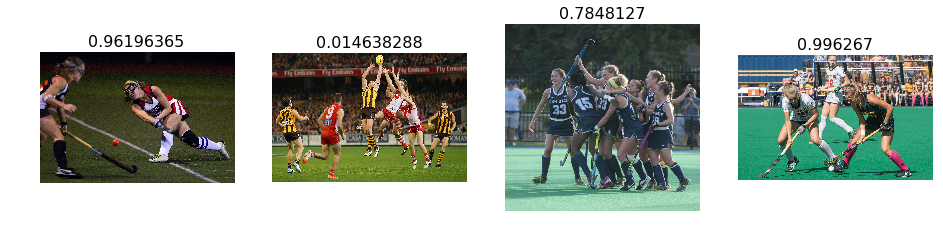

In [85]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [86]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

ValueError: a must be non-empty

Most correct AFL


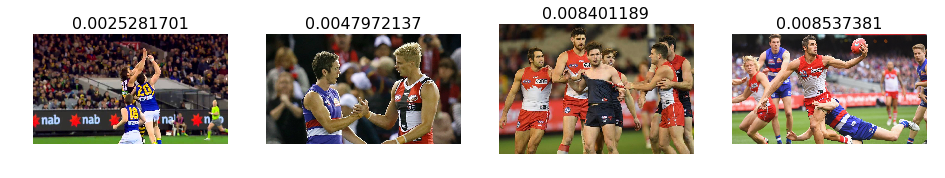

In [87]:
plot_val_with_title(most_by_correct(0, True), "Most correct AFL")

Most correct Hockey


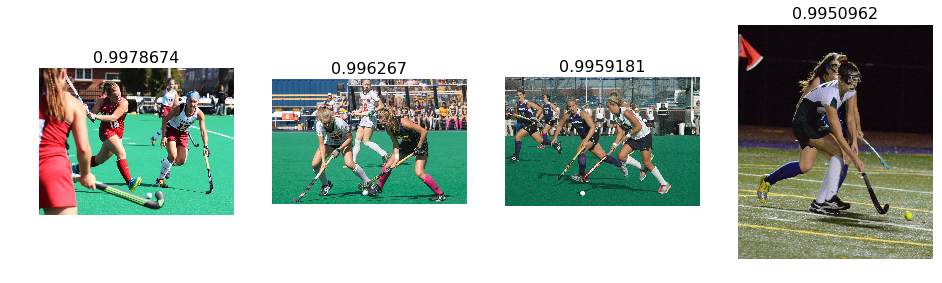

In [88]:
plot_val_with_title(most_by_correct(1, True), "Most correct Hockey")

Most uncertain predictions


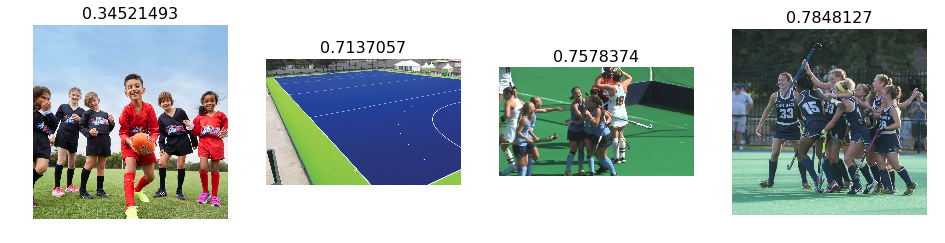

In [89]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")